In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
!pip install noisereduce
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import time
import noisereduce as nr
from scipy.io import wavfile
import matplotlib.pyplot as plt

import librosa
import librosa.display

from pydub import AudioSegment 
from pydub.utils import make_chunks

In [5]:
#Helper function to perform required preprocessing

#Processing audio clips to create 3 second chunks
def process_audio(filename):
    myaudio = AudioSegment.from_file(filename, "wav") 
    chunk_length_ms = 3000
    chunks = make_chunks(myaudio,chunk_length_ms)  
    print(len(chunks))
    for i, chunk in enumerate(chunks):
        filename = os.path.splitext(filename)[0]
        chunk_name = './chunked/' + filename + "_{0}.wav".format(i) 
        chunk.export(chunk_name, format="wav")

#Eliminiting noise fron audio clips
def eliminate_noise(path, filename):
    audio, sample_rate = librosa.load(path)
    reduced_noise = nr.reduce_noise(y=audio, sr=sample_rate)
    filename = os.path.splitext(filename)[0]
    wavfile.write('./reduced/' + filename + "_reduced.wav", sample_rate, reduced_noise)

#Converts audio clips to spectrograms 
def convert_to_spec(path, filename):
    x, sr = librosa.load(path)
    filename = os.path.splitext(filename)[0]
    fname = './images/' + filename + '.png'
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    fig = plt.figure(frameon = False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    fin = librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    fig.savefig(fname, dpi='figure')
    plt.close();

In [ ]:
!ls

drive  sample_data


In [ ]:
#This code window performs all required preprocessing to the audio files
#This will help us study the data and create a dataset 
cwd = os.listdir('data')

for folder in cwd:
    
    data_path = './data/'+folder
    os.chdir(data_path)
    
    try:
        os.makedirs('chunked')
        os.makedirs('reduced')
        os.makedirs('images')
    except:
        pass
    
    #start_time = time.perf_counter()
    
    audio_file = os.listdir()
    for file in audio_file:
        if ('.wav' in file):
            process_audio(file)
    print("Audio Splitting Complete")
    
    #print(time.perf_counter() - start_time, "seconds")
    
    #start_time = time.perf_counter()
    
    chunked_files = os.listdir('chunked')
    for file in chunked_files:
        path = "./chunked/"+ file
        eliminate_noise(path, file)
    print("Eliminated Noise")
    
    #print(time.perf_counter() - start_time, "seconds")
    
    #start_time = time.perf_counter()
    
    reduced_files = os.listdir('reduced')
    for file in reduced_files:
        path = "./reduced/"+ file
        convert_to_spec(path, file)
    print("Spectrograms Generated")
    
    #print(time.perf_counter() - start_time, "seconds")
    
    os.chdir('../') 
    os.chdir('../') 

print("Preprocessing Complete")

Audio Splitting Complete
Eliminated Noise
Spectrograms Generated
600
Audio Splitting Complete
Eliminated Noise
Spectrograms Generated
Preprocessing Complete


In [ ]:
!ls

In [ ]:
# convertTo16Bit('dataset')
# eliminate_noise('clean_noise/tiger.wav', 'tiger')

# Main model building
### SMM01167_20221109_182902.wav

In [6]:
!pip install tensorflow tensorflow_io


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 30.9 MB/s eta 0:00:00


In [ ]:
# !pip install librosa

In [7]:
import os
import csv
import pandas as pd
import datetime
from itertools import groupby
from matplotlib import pyplot as plt

import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [8]:
#This function loads an audio clip and resamples it to 16000 samples/second
# import librosa    

def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    # wav, s = librosa.load(filename, sr=16000)
 

    return wav

In [ ]:
!ls
!pwd

In [ ]:
#upload moan data (3 sec audio), them create Moan folder, then move them to Moan folder
!mv /content/*.wav /content/NoMoan

In [42]:
#Tensorflow only works with 16-bit .wav files
#This function converts them into 16-bit and stores them to the target directory

import soundfile
import os

def convertTo16Bit(directory):
    for file in os.listdir(directory):
         if(file.endswith('.wav')):
                nameSolo = file.rsplit('.', 1)[0]
                path = directory + '/' + file
                #print(directory + f'/{nameSolo}')
                data, samplerate = soundfile.read(path)

                soundfile.write('/content/Test16BIT' + nameSolo + '_16BIT.wav', data, samplerate, subtype='PCM_16')
                #print("converting " + file + "to 16 - bit")

In [43]:
convertTo16Bit('/content/Test')

In [ ]:
!mv /content/*.wav /content/NoMoan16BIT

In [9]:
#Storing samples from each class for test runs

TIGER_FILE = "/content/drive/MyDrive/Moan16BIT/Moan16BITSMM01167_20221109_182902_111_16BIT.wav"
NOT_TIGER_FILE = "/content/drive/MyDrive/NoMoan16BIT/NoMoan16BITSMM01167_20221109_182902_114_16BIT.wav"

In [10]:
#Loading test files and assigning them to variables
wave = load_wav_16k_mono(TIGER_FILE)
nwave= load_wav_16k_mono(NOT_TIGER_FILE)

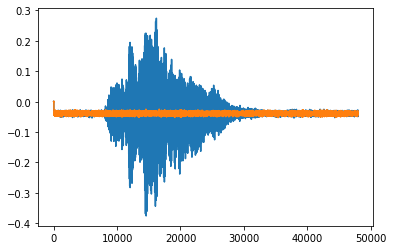

In [11]:
#Plotting example positive and negative samples
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
!ls /content/Moan16BIT/

ls: cannot access '/content/Moan16BIT/': No such file or directory


In [12]:
#This creates a dataset from the positive and negative samples and loads them onto two variables

# this the folder for the imgs
pos = tf.data.Dataset.list_files('/content/drive/MyDrive/Moan16BIT/*.wav')
neg = tf.data.Dataset.list_files('/content/drive/MyDrive/NoMoan16BIT/*.wav')

In [13]:
len(pos), len(neg)

(32, 32)

In [14]:
#Adding samples labels to each sample set. potsitive examples are assigned label '1' and negative samples are assigned label '0'
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
#Consolidating all samples under one variable sequentially
data = positives.concatenate(negatives)
data.as_numpy_iterator().next() , len(data)

((b'/content/drive/MyDrive/Moan16BIT/Moan16BITSMM01167_20221109_182902_162_16BIT.wav',
  1.0),
 64)

In [15]:
negatives.as_numpy_iterator().next() 

(b'/content/drive/MyDrive/NoMoan16BIT/NoMoan16BITSMM01167_20221109_182902_128_16BIT.wav',
 0.0)

In [16]:
#This function loads an audio clip and converts it to a spectrogram for further processing

def preprocess(file_path, label): 
    print(file_path)
    wav = load_wav_16k_mono(file_path)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=320, window_fn=None)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    # print(spectrogram, label)
    return spectrogram, label

b'/content/drive/MyDrive/Moan16BIT/Moan16BITSMM01167_20221109_182902_185_16BIT.wav'  |  1.0
b'/content/drive/MyDrive/Moan16BIT/Moan16BITSMM01167_20221109_182902_185_16BIT.wav'


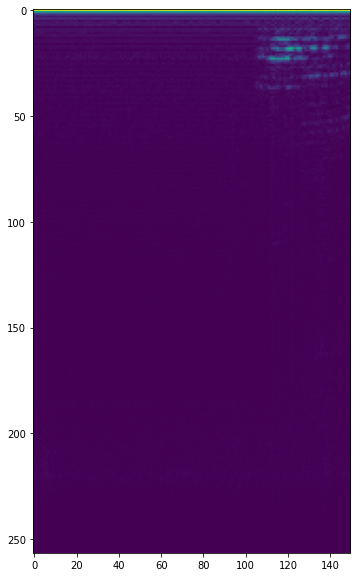

In [17]:
#Extracting one sample and plotting it's spectrogram for analysis

filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
print(filepath, " | ", label)
spectrogram, label = preprocess(filepath, label)

plt.figure(figsize=(20,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

b'/content/drive/MyDrive/NoMoan16BIT/NoMoan16BITSMM01167_20221109_182902_93_16BIT.wav'
b'/content/drive/MyDrive/NoMoan16BIT/NoMoan16BITSMM01167_20221109_182902_93_16BIT.wav'  |  0.0
spectrogram shape  (150, 257, 1)


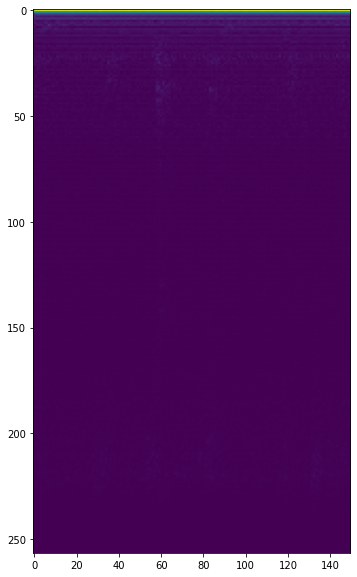

In [18]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
print(filepath, " | ", label)
print("spectrogram shape ",spectrogram.shape)
plt.figure(figsize=(20,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [19]:
# for i in data:
#   filepath, label = data.as_numpy_iterator().next()
#   print(filepath, " | ", label )
list(data.as_numpy_iterator())

[(b'/content/drive/MyDrive/Moan16BIT/Moan16BITSMM01167_20221109_182902_80_16BIT.wav',
  1.0),
 (b'/content/drive/MyDrive/Moan16BIT/Moan16BITSMM01167_20221109_182902_156_16BIT.wav',
  1.0),
 (b'/content/drive/MyDrive/Moan16BIT/Moan16BITSMM01167_20221109_182902_154_16BIT.wav',
  1.0),
 (b'/content/drive/MyDrive/Moan16BIT/Moan16BITSMM01167_20221109_182902_158_16BIT.wav',
  1.0),
 (b'/content/drive/MyDrive/Moan16BIT/Moan16BITSMM01167_20221109_182902_129_16BIT.wav',
  1.0),
 (b'/content/drive/MyDrive/Moan16BIT/Moan16BITSMM01167_20221109_182902_116_16BIT.wav',
  1.0),
 (b'/content/drive/MyDrive/Moan16BIT/Moan16BITSMM01167_20221109_182902_77_16BIT.wav',
  1.0),
 (b'/content/drive/MyDrive/Moan16BIT/Moan16BITSMM01167_20221109_182902_125_16BIT.wav',
  1.0),
 (b'/content/drive/MyDrive/Moan16BIT/Moan16BITSMM01167_20221109_182902_132_16BIT.wav',
  1.0),
 (b'/content/drive/MyDrive/Moan16BIT/Moan16BITSMM01167_20221109_182902_78_16BIT.wav',
  1.0),
 (b'/content/drive/MyDrive/Moan16BIT/Moan16BITSMM0116

In [20]:
#Creating a data loading pipeline, that shuffles the dataset and creates batches of 16 images

# data = tf.data.Dataset.map(preprocess)
data= data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Tensor("args_0:0", shape=(), dtype=string)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
len(data)

4

In [22]:
#Splitting dataset into train and test sets
train = data.take(3)
test = data.skip(3).take(1)

In [23]:
len(train),len(test)

(3, 1)

In [24]:
#Extracting random example from train set
samples, labels = train.as_numpy_iterator().next()

In [25]:
#Outputs shape of example train sample. 
#This gives the input_shape for the Convolutional Neural Network
samples.shape

(16, 150, 257, 1)

In [26]:
#Creating a sequential convolutional neural network model

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(150,257,1)))
model.add(Conv2D(5, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
#Model compilation
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(), tf.keras.metrics.Accuracy()])

In [30]:
#Outputs model summary and model parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 255, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 253, 5)       725       
                                                                 
 flatten (Flatten)           (None, 184690)            0         
                                                                 
 dense (Dense)               (None, 128)               23640448  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,641,462
Trainable params: 23,641,462
Non-trainable params: 0
_________________________________________________________________


In [31]:
#Initiating training instance and storing results in 'hist' variable
hist = model.fit(train, epochs=30, validation_data=test)

Epoch 1/30
3/3 [==============================] - 7s 1s/step - loss: 1.7054 - recall: 0.6818 - precision: 0.4545 - accuracy: 0.1667 - val_loss: 1.3961 - val_recall: 0.2222 - val_precision: 1.0000 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 4s 1s/step - loss: 0.6681 - recall: 0.4348 - precision: 1.0000 - accuracy: 0.0000e+00 - val_loss: 0.1974 - val_recall: 1.0000 - val_precision: 1.0000 - val_accuracy: 0.1250
Epoch 3/30
3/3 [==============================] - 4s 2s/step - loss: 0.2097 - recall: 1.0000 - precision: 0.9630 - accuracy: 0.2083 - val_loss: 0.1455 - val_recall: 1.0000 - val_precision: 1.0000 - val_accuracy: 0.2500
Epoch 4/30
3/3 [==============================] - 3s 1s/step - loss: 0.1176 - recall: 1.0000 - precision: 1.0000 - accuracy: 0.1667 - val_loss: 0.1081 - val_recall: 0.8000 - val_precision: 1.0000 - val_accuracy: 0.0625
Epoch 5/30
3/3 [==============================] - 4s 2s/step - loss: 0.1187 - recall: 0.9091 - precision: 1.0000 - a

In [32]:
hist.history

{'loss': [1.705384373664856,
  0.6681067943572998,
  0.20973944664001465,
  0.11764753609895706,
  0.11869438737630844,
  0.10801669955253601,
  0.03341338410973549,
  0.017793817445635796,
  0.018289605155587196,
  0.012396800331771374,
  0.004532537888735533,
  0.0037030342500656843,
  0.0021679040510207415,
  0.001379361841827631,
  0.0007632551714777946,
  0.0005337366019375622,
  0.0003898116701748222,
  0.00030211827834136784,
  0.000201381670194678,
  0.00018128094961866736,
  0.00016106881957966834,
  0.00015783235721755773,
  0.00014050237950868905,
  0.00012344149581622332,
  7.541820377809927e-05,
  7.937716145534068e-05,
  7.397255831165239e-05,
  8.222270844271407e-05,
  7.748830103082582e-05,
  6.117708107922226e-05],
 'recall': [0.6818181872367859,
  0.43478259444236755,
  1.0,
  1.0,
  0.9090909361839294,
  0.875,
  0.9599999785423279,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1

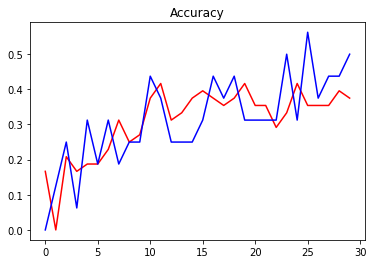

In [33]:
#Plotting accuracy
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

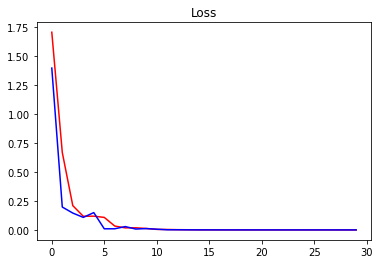

In [34]:
#Plotting Loss
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

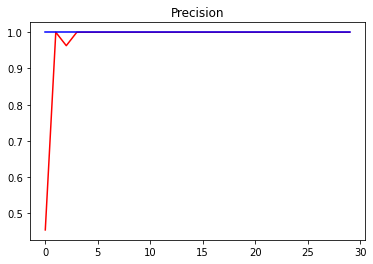

In [36]:
#Plotting Precision
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

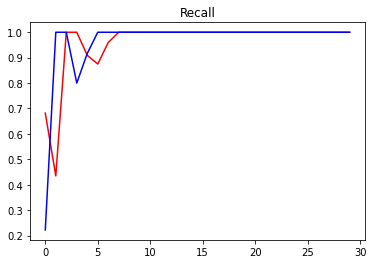

In [37]:
#Plotting Recall
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [38]:
#Extracting an example from the test set to check model performance
len(train),len(test)

(3, 1)

In [39]:
#Extracting an example from the test set to check model performance
X_test, y_test = test.as_numpy_iterator().next()
X_test, y_test

(array([[[[1.1175981e+01],
          [6.1895080e+00],
          [1.2205081e+00],
          ...,
          [1.9183746e-02],
          [1.9148134e-02],
          [1.9146919e-02]],
 
         [[1.2451620e+01],
          [5.8105764e+00],
          [2.2885311e+00],
          ...,
          [2.9986851e-02],
          [3.8757075e-02],
          [3.6554337e-03]],
 
         [[1.2412807e+01],
          [5.8288918e+00],
          [2.2433436e+00],
          ...,
          [3.0515516e-02],
          [3.9773092e-02],
          [2.6173592e-03]],
 
         ...,
 
         [[1.2412812e+01],
          [5.7572441e+00],
          [2.3256986e+00],
          ...,
          [2.8974097e-02],
          [3.7239365e-02],
          [1.0461807e-03]],
 
         [[1.2350285e+01],
          [5.8462806e+00],
          [2.1907568e+00],
          ...,
          [2.8762810e-02],
          [3.7976727e-02],
          [4.4679642e-04]],
 
         [[1.2425693e+01],
          [5.8306327e+00],
          [2.2514410e+00],
   

In [40]:
#Testing model by making prediction from extracted test sample
yhat = model.predict(X_test)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
print(yhat)
print(y_test)

1/1 [==============================] - 0s 322ms/step
[1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]
[1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.]


## Build Function to Convert Clips into Windowed Spectrograms

In [44]:
#Testing functions that will be used to ensure correctness
RECORDING = os.path.join('Test','Test16BITSMM01167_20221109_175902_test_16BIT.wav')
print(RECORDING)
test_wav = load_wav_16k_mono(RECORDING)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(test_wav, test_wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
samples, index = audio_slices.as_numpy_iterator().next()
samples.shape, len(audio_slices)

Test/Test16BITSMM01167_20221109_175902_test_16BIT.wav


((1, 48000), 599)

In [45]:
#This function performs required preprocessing for test dataset
def preprocess_dataset(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=320)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [46]:
#Splitting extracted sample into 3 second clips
audio_slices = tf.keras.utils.timeseries_dataset_from_array(test_wav, test_wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
#Mapping preprocessing function to extracted sample
audio_slices = audio_slices.map(preprocess_dataset)
#Creating batches of 64
audio_slices = audio_slices.batch(64)

In [47]:
#Splitting extracted sample into 3 second clips
audio_slices = tf.keras.utils.timeseries_dataset_from_array(test_wav, test_wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
#Mapping preprocessing function to extracted sample
audio_slices = audio_slices.map(preprocess_dataset)
#Creating batches of 64
audio_slices = audio_slices.batch(64)

In [48]:
#Performing predictions on the extracted sample to and creating class prediction array
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

10/10 [==============================] - 9s 724ms/step


In [49]:
yhat

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [51]:
#Grouping class predictions and storing call density in 'calls' variable
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [52]:
yhat, " | calls ", calls

([0, 1, 0, 1, 0, 1, 0, 1, 0], ' | calls ', 4)

In [53]:
#This code window performs the prediction on a set of audio files and stores them into an array against the name of the file

results = {}
for file in os.listdir('/content/Test'):
    FILEPATH = os.path.join('/content/Test', file)
    print(FILEPATH)
    
    wav = load_wav_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_dataset)
    audio_slices = audio_slices.batch(16)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

/content/Test/Test16BITSMM01167_20221109_175902_test_16BIT.wav


38/38 [==============================] - 11s 280ms/step
/content/Test/.ipynb_checkpoints


FailedPreconditionError: ignored

In [54]:
results

{'Test16BITSMM01167_20221109_175902_test_16BIT.wav': array([[2.0865914e-04],
        [1.8604846e-04],
        [2.0765529e-04],
        [1.7051699e-04],
        [2.0749299e-04],
        [2.4353593e-04],
        [2.1602397e-04],
        [2.0110003e-04],
        [2.0357834e-04],
        [1.9660342e-04],
        [1.8966969e-04],
        [2.0334710e-04],
        [1.8943762e-04],
        [1.8744644e-04],
        [2.0739449e-04],
        [1.9410597e-04],
        [1.8971182e-04],
        [1.8761899e-04],
        [1.8111839e-04],
        [1.8960150e-04],
        [2.0936503e-04],
        [1.7603824e-04],
        [1.7661459e-04],
        [1.7416281e-04],
        [1.9116227e-04],
        [1.9054991e-04],
        [3.0910924e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [9.9999022e-01],
        [1.0000000e+00],
        [9.7799706e-01],
        [1.0000000e+00],
        [9.9296308e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00]

In [55]:
for key in results.keys():
  print(len(results[key]))

599


In [56]:
#Converts predictions stored in the results file to class predictions
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
#class_preds

In [57]:
class_preds.items()

dict_items([('Test16BITSMM01167_20221109_175902_test_16BIT.wav', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [58]:
#Functions to facilitate creating a csv file and storing time stepped results
def convert(n):
    return str(datetime.timedelta(seconds = n))

def save_results(directory, dictionary):    
    try:
        os.mkdir(directory)
    except:
        pass
    
    for file, logits in class_preds.items():
      col_len = len(logits)
      sec = [x for x in range(0, col_len*3, 3)]
      form = [convert(x) for x in sec]

      df = pd.DataFrame({'Timestep': form, 'Prediction': logits}).set_index('Timestep')
      path = directory + '/'+ file[0:-4] + '_output.xlsx'
      df.to_excel(path)

In [59]:
save_results('/content/TIMED_RESULTS', class_preds)

In [60]:
#This code window, groups consecutive prediction into a single value and outputs sum of all positive samples.
#This gives us the call density for each file
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
#postprocessed

In [61]:
#Stores call density into a csv file for further study
with open('/content/results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['Recording', 'Main Calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])